In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import os
from collections import Counter
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

def seed_assign(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)


In [17]:
data_path = '/data2/spike_sorting/neuropixels_choi'
filename = ["/set1/20141202_all_es", "/set2/20150924_1_e", "/set3/20150601_all_s", "/set4/20150924_1_GT"]

In [18]:
index = 0
ground_truth_path = data_path+filename[index]+'_gtTimes.mat'

In [19]:
# 근데 prob파일에 129번째 채널이 없네?


## Merge

In [20]:
width = 1_500_000
max_iter = 5
n_channel = 129
n_unit = 7 if index != 2 else 8 # set2는 예외적으로 unit 8개다.
seed_assign(42)

In [21]:
all_waveforms = []
for i in range(max_iter):
    start_index = i * width + 1  # 현재 반복에서 시작 인덱스 계산
    end_index = (i + 1) * width  # 현재 반복에서 끝 인덱스 계산
    
    current_dataset = f"{data_path}{filename[index]}_start{start_index}_end{end_index}.mat"
    mat1 = io.loadmat(current_dataset)
    all_waveforms.append(mat1['raw_data'])
merged_waveform = np.concatenate(all_waveforms, axis=1)
print(merged_waveform.shape)
print(mat1['raw_data'].dtype)


(129, 7500000)
int16


In [22]:
ground_truth_path = data_path+filename[index]+'_gtTimes.mat'

mat1 = io.loadmat(ground_truth_path)
spike_times_int_all_units = []
for i in range(n_unit):
    spike_times_int_all_units.append(mat1['gtTimes'][0][i][:,0])

spike_chans_int_all_units = []
for i in range(n_unit):
    spike_chans_int_all_units.append(mat1['gtChans'][0][i][:,0])
    
print('유닛 개수', mat1['gtTimes'][0].shape)

유닛 개수 (7,)


In [23]:
print(len(merged_waveform))
print(merged_waveform[0].shape)

129
(7500000,)


In [24]:
print(len(spike_times_int_all_units))
print(spike_times_int_all_units[0].shape)

7
(15432,)


In [25]:
total_spike = 0
for i in range(n_unit):
    total_spike += spike_times_int_all_units[i].shape[0]
print('모든 채널의 모든 스파이크 개수 합', total_spike)

모든 채널의 모든 스파이크 개수 합 77151


In [26]:
print(len(spike_chans_int_all_units))
print(spike_chans_int_all_units[0].shape)
# 유닛별 잘 나오는 channel

7
(12,)


In [27]:
np.save(f"{data_path}{filename[index]}_merged.npy", merged_waveform)

# Cropping Spike for AE

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import os
from collections import Counter
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

def seed_assign(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

my_seed = 42
seed_assign(my_seed)

In [37]:
data_path = '/data2/spike_sorting/neuropixels_choi'
filename = ["/set1/set1", "/set2/set2", "/set3/set3", "/set4/set4"]

In [38]:
index = 0 # 0-->set1, 1-->set2, 2-->set3, 3-->set4
n_unit = 7 if index != 2 else 8 # set3는 예외적으로 unit 8개다.

# method = 'mean'
# method = 'grad_offset'
method = 'neo_offset'

spike_class = f"{data_path}{filename[index]}_class_{method}.csv"
spike_raw = f"{data_path}{filename[index]}_waveform_{method}.csv"




In [39]:
# Class 파일 로드 (한 열로 저장된 값들)
with open(spike_class, "r") as f:
    class_data = np.array([int(line.strip()) for line in f])[1:]

# Waveform 파일 로드 (반점으로 구분된 행렬 형태)
waveform_data = np.loadtxt(spike_raw, delimiter=",", dtype=np.int16).T


In [40]:
print(f"{'Property':<20} | {'Value'}")
print("-" * 40)
print(f"{'Waveform Data Type':<20} | {waveform_data.dtype}")
print(f"{'Waveform Data Shape':<20} | {waveform_data.shape}")
print(f"{'Class Data Shape':<20} | {class_data.shape}")

Property             | Value
----------------------------------------
Waveform Data Type   | int16
Waveform Data Shape  | (77151, 141)
Class Data Shape     | (77151,)


In [41]:
training_spike_group_reshape = waveform_data
spike_length = waveform_data.shape[1]
training_spike_group_label_reshape = class_data.reshape(-1, 1)
print('총 스파이크 개수', training_spike_group_label_reshape.shape)

총 스파이크 개수 (77151, 1)


In [42]:
training_spike_group_reshape.shape

(77151, 141)

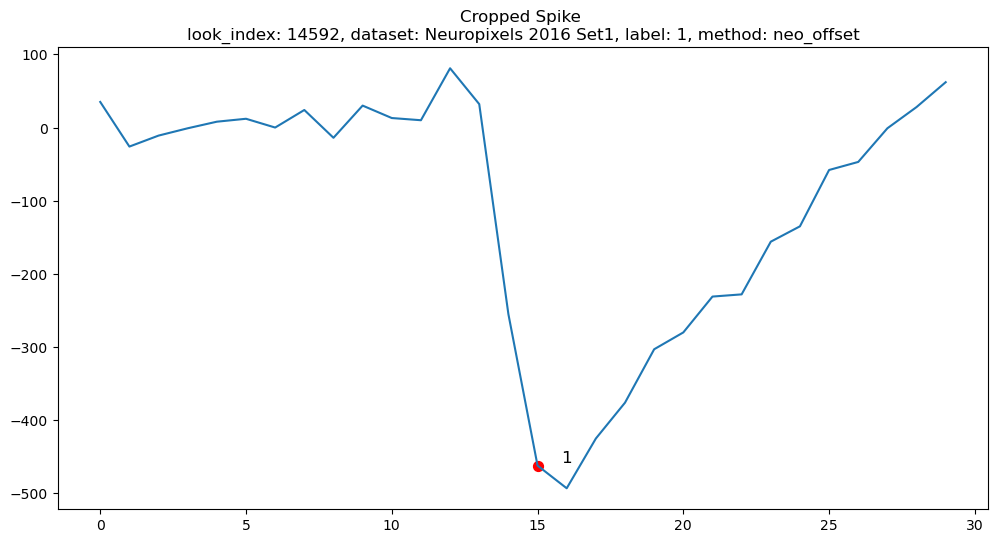

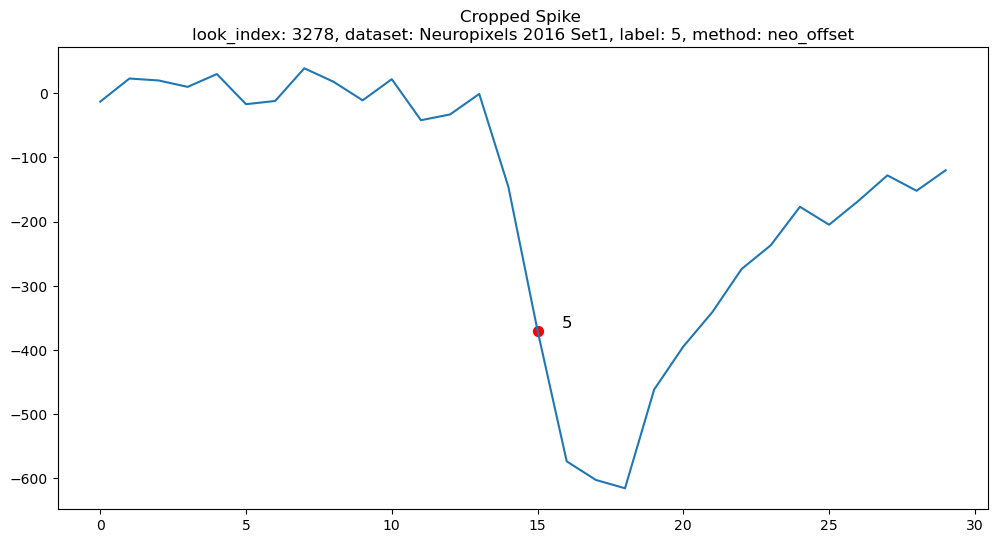

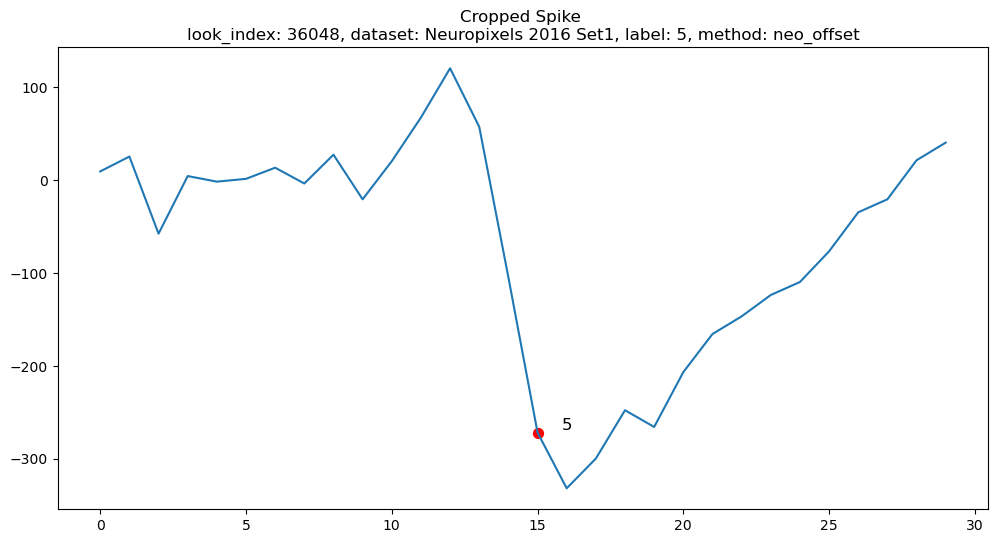

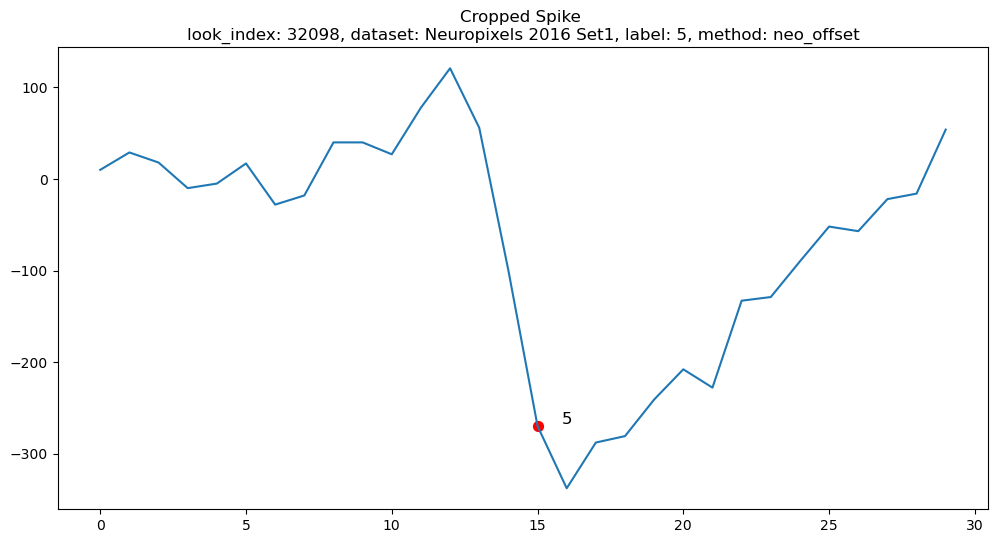

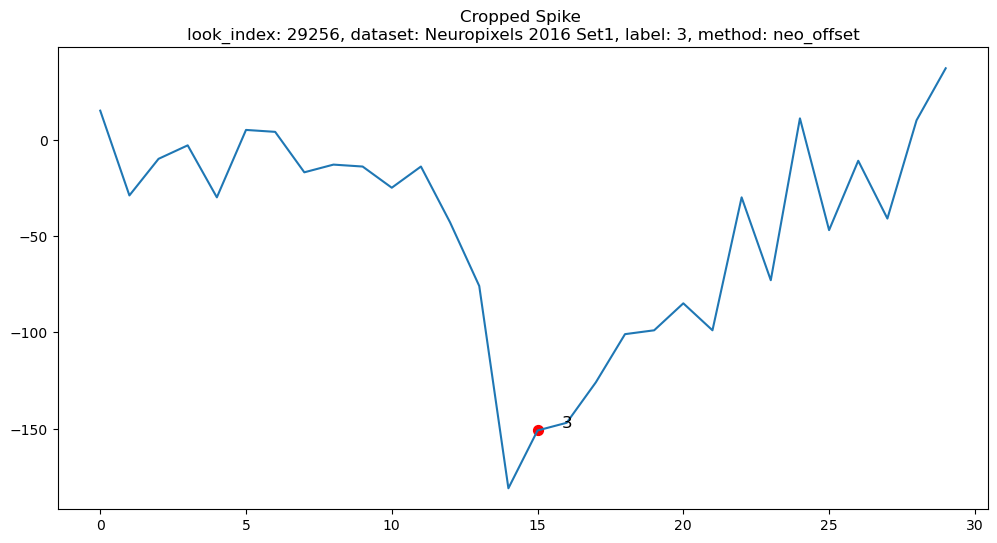

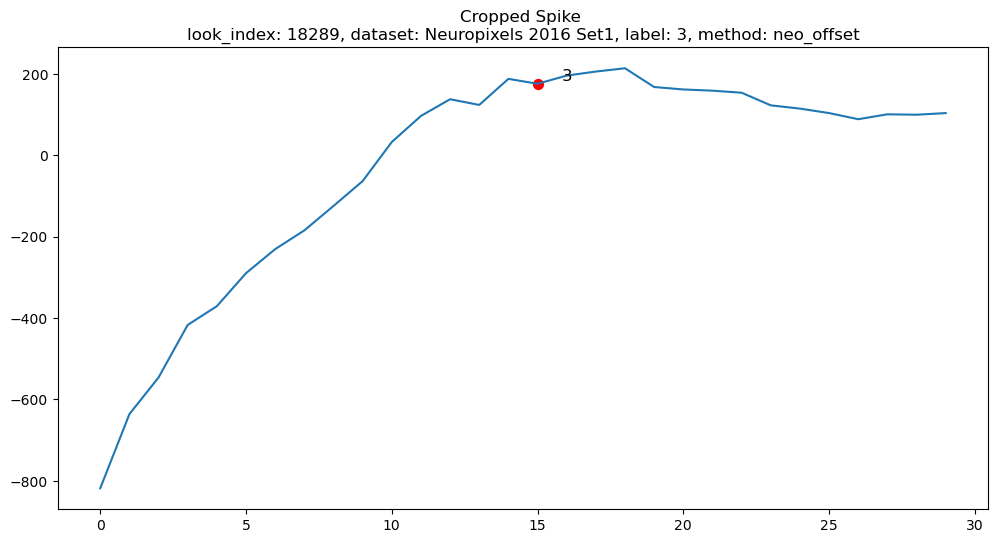

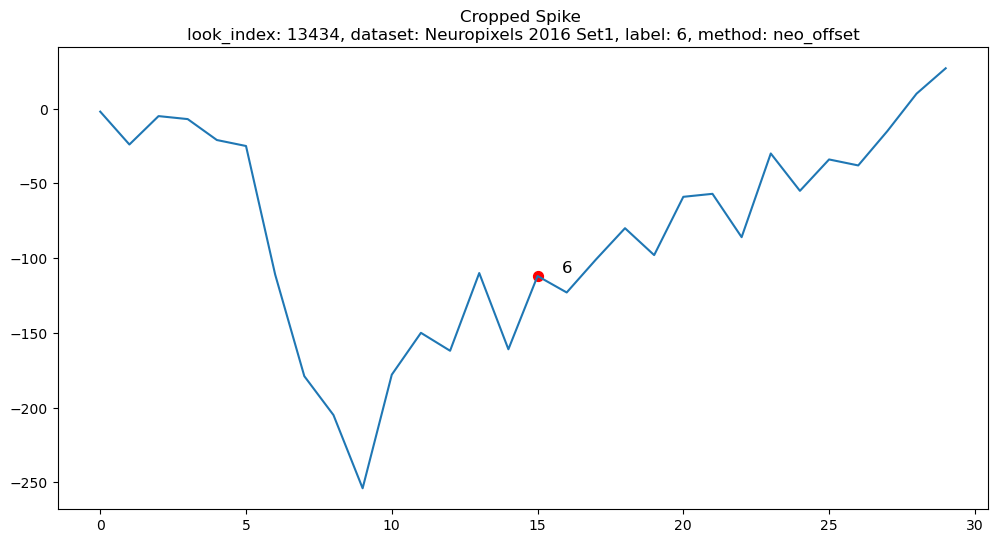

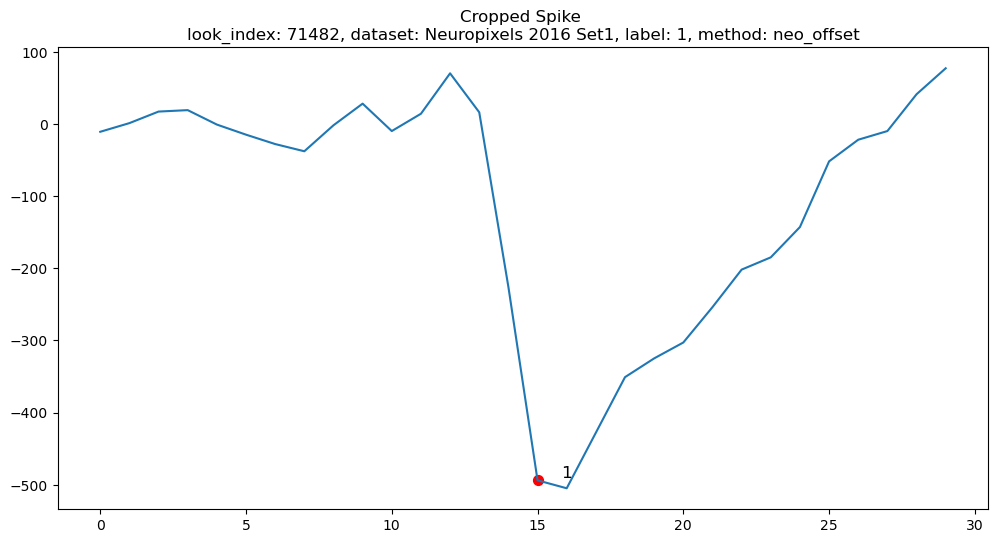

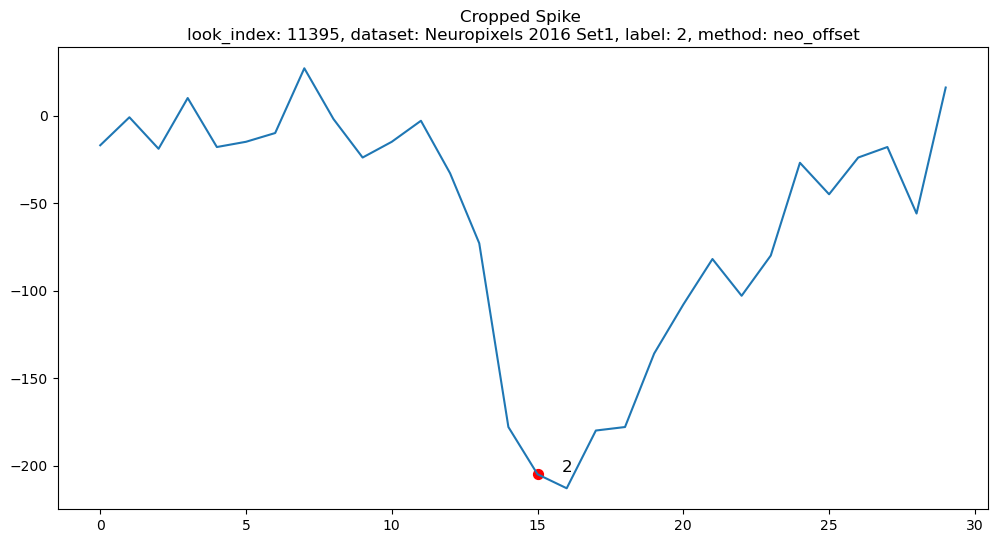

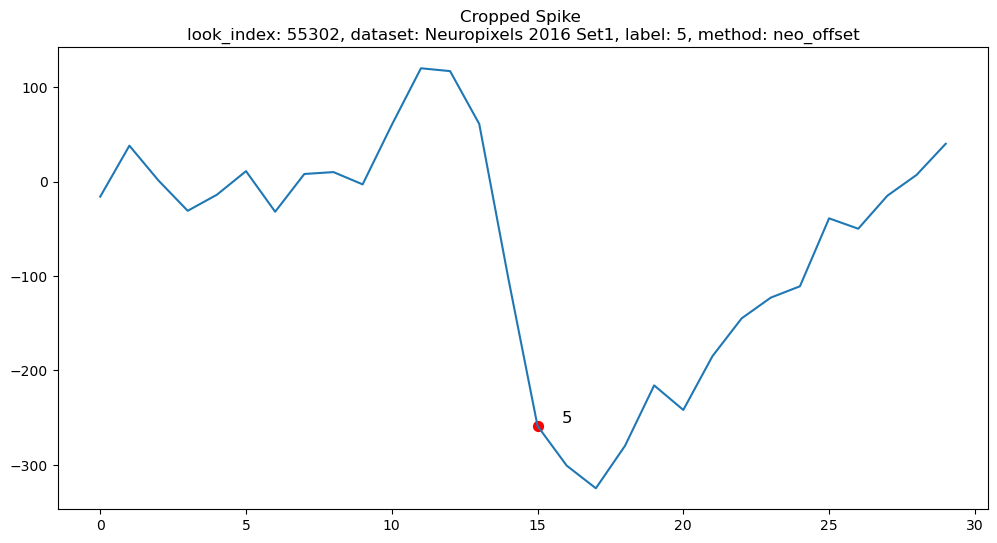

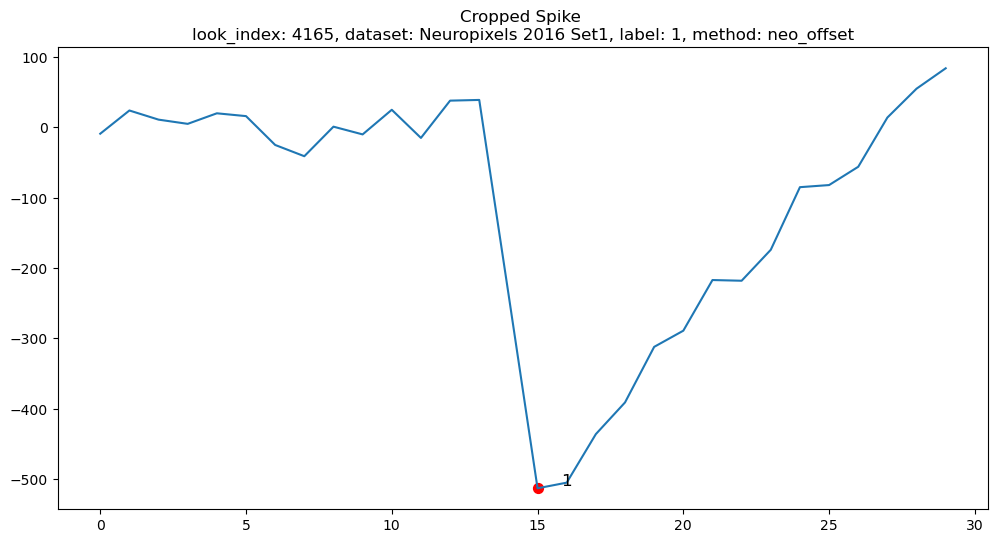

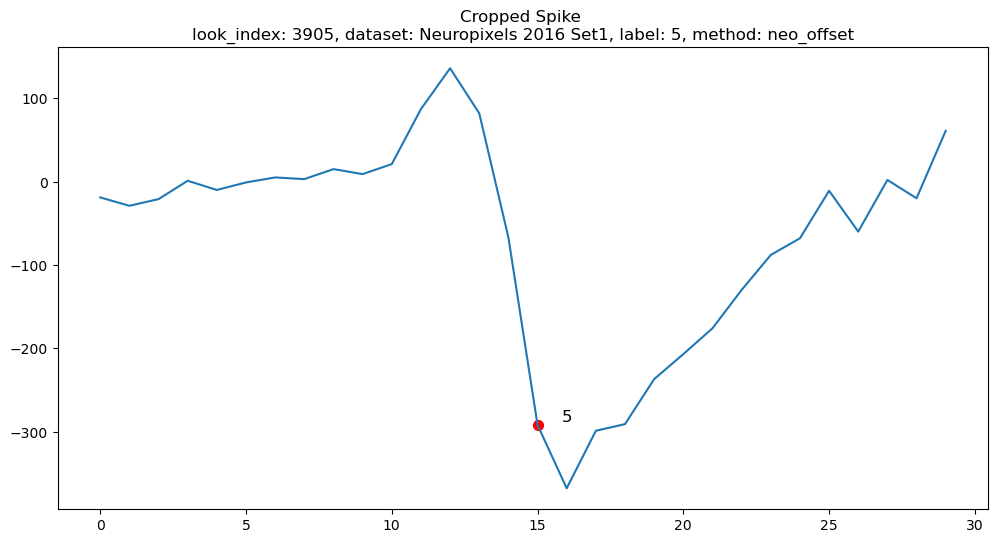

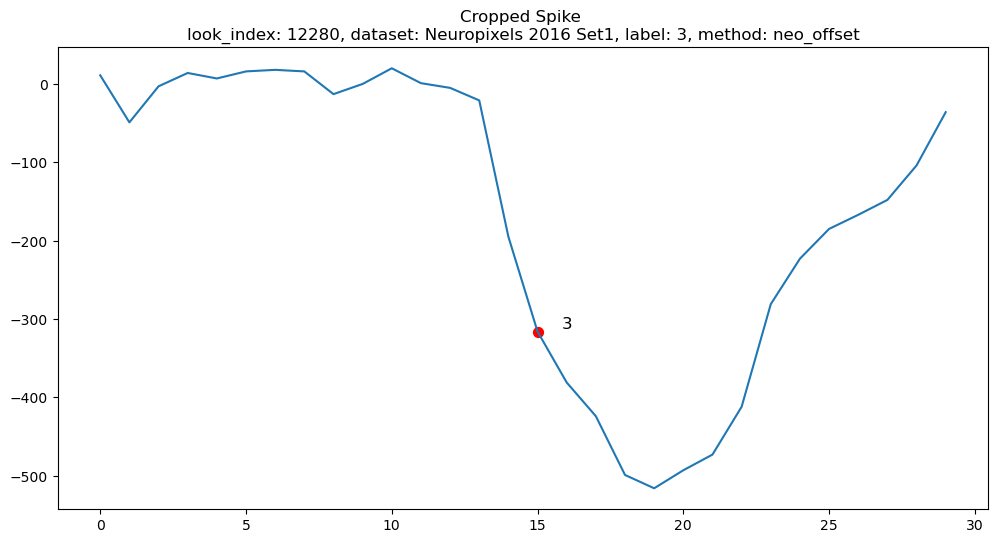

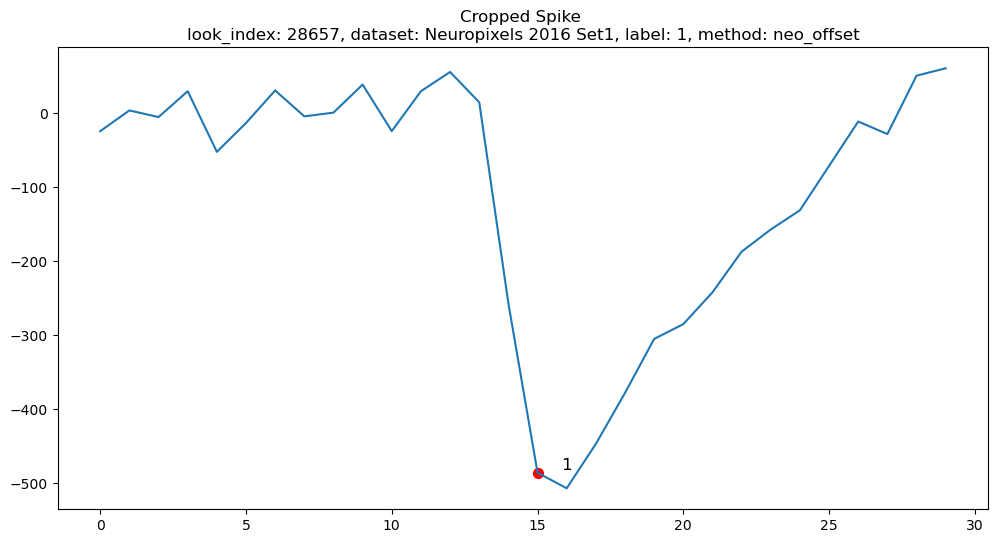

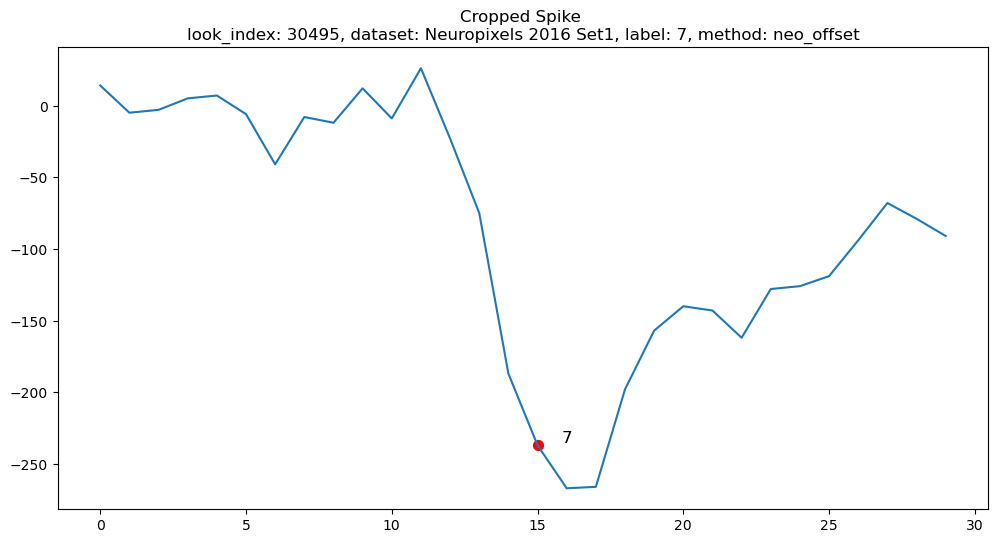

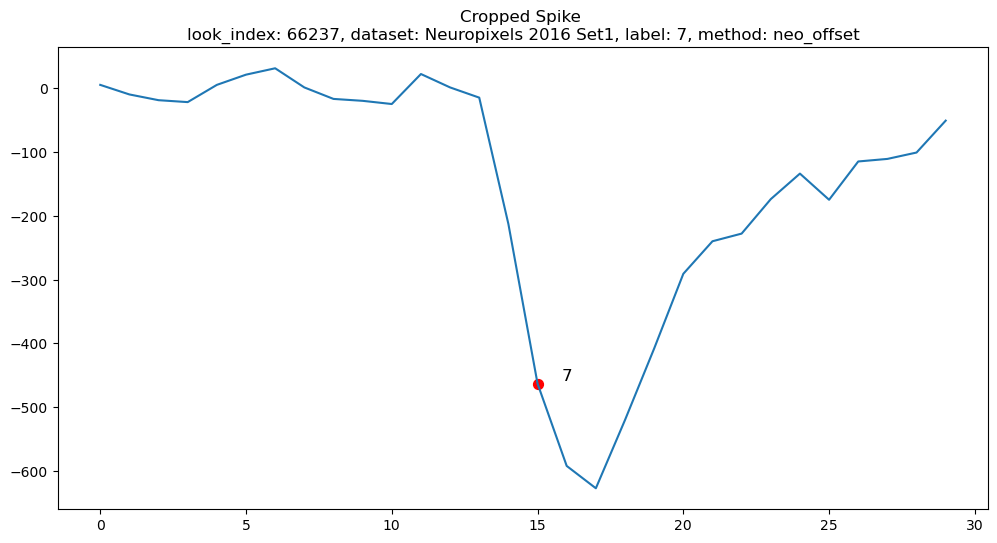

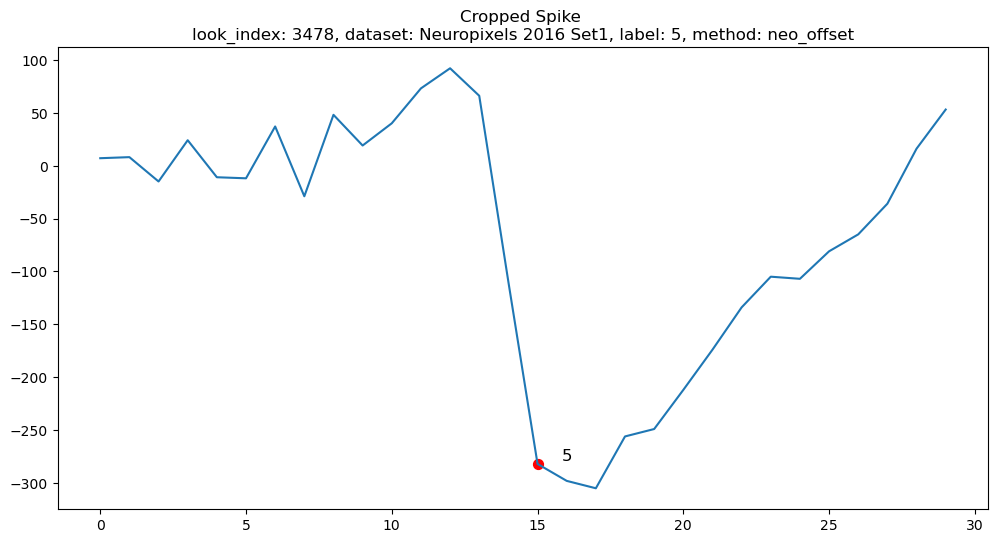

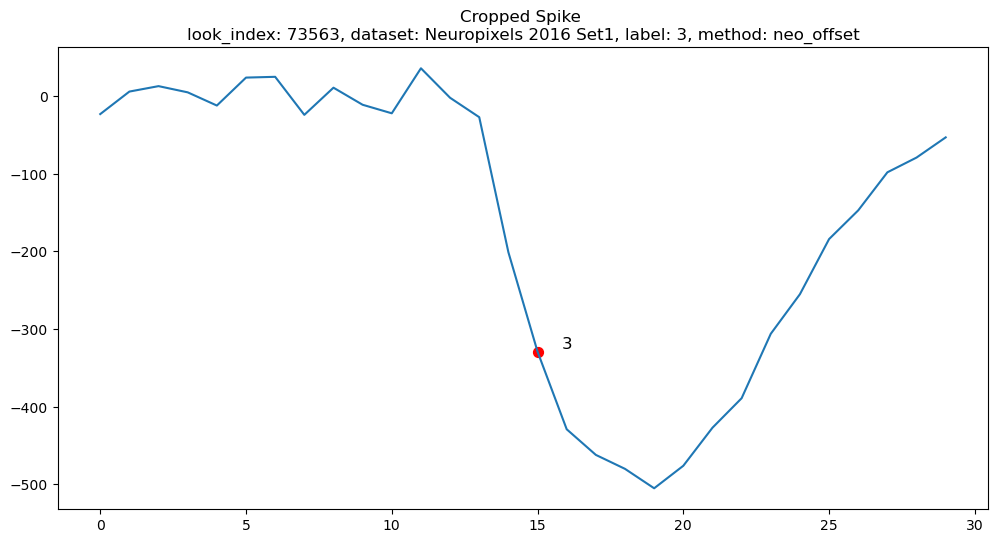

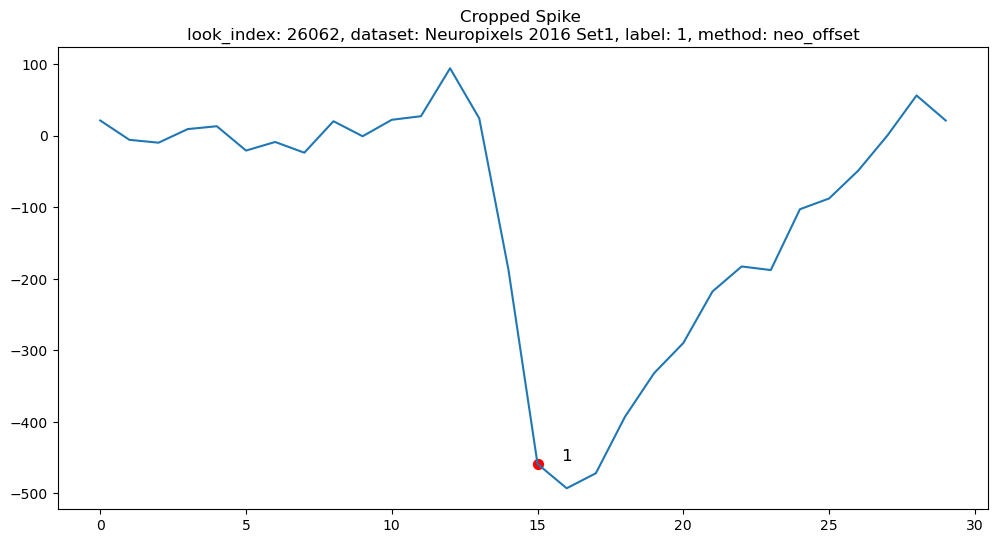

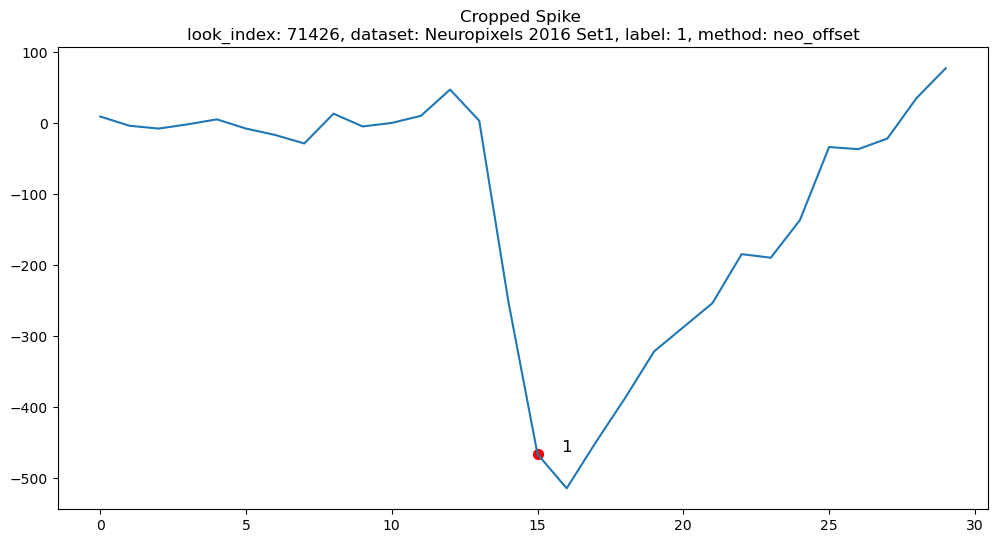

In [43]:
figure_vertical_window = [(-2000,300),(-500,300),(2400, 2800),(2500,3500)]
ylim_ground  = figure_vertical_window[index][0]
ylim_ceiling = figure_vertical_window[index][1]

print_num = 20
spike_exact = 70 # matlab에서 crop할 때 70의 index가 ground truth timing임.
want_to_look_just_n_sample = 30 # max: 70
random_look_index_list = random.sample(range(np.shape(training_spike_group_reshape)[0]), print_num)
# random_look_index_list = range(print_num)
# print(random_look_index_list)
for look_index in random_look_index_list:
    plt.figure(figsize=(12, 6))
    x = np.arange(0, want_to_look_just_n_sample//2 + want_to_look_just_n_sample//2 , 1)
    more_sliced_spike = training_spike_group_reshape[look_index, spike_exact - want_to_look_just_n_sample//2:spike_exact - want_to_look_just_n_sample//2 + want_to_look_just_n_sample]
    plt.plot(x, more_sliced_spike) 
    # plt.ylim(ylim_ground, ylim_ceiling)  # y축 범위를 -1.5에서 1.5로 고정

    # # x=70에 세로로 빨간 선 추가
    # plt.axvline(x=70, color='r', linestyle='--', linewidth=0.5)  # 세로선 그리기
    

    central_point = want_to_look_just_n_sample//2 # spike 지점
    plt.scatter(central_point, more_sliced_spike[central_point], color='r', s=50, label="Red Point")  # 빨간 점 표시
    plt.text(central_point + 1, more_sliced_spike[central_point], str(int(training_spike_group_label_reshape[look_index][0])), color='black', fontsize=12, ha='center', va='bottom')  # 레이블 값 텍스트
    
    plt.title(f'Cropped Spike \nlook_index: {look_index}, dataset: Neuropixels 2016 Set{index+1}, label: {int(training_spike_group_label_reshape[look_index][0])}, method: {method}')
